## Прогнозирование временных рядов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

import statsmodels.api as sm

from calendar import monthrange

#### 1. В приложенном файле — данные по ежемесячному уровню производства молока в фунтах на одну корову:

Загрузите ряд, создайте новый ряд значений среднего дневного уровня производства молока в фунтах на одну корову, поделив на число дней в месяце (вычисляется с помощью функции monthrange из пакета calendar). Постройте график полученного ряда; какой из приведённых ниже графиков у вас получился?

In [2]:
data = pd.read_csv('monthly-milk-production.csv', sep=';', index_col=['month'], parse_dates=True, dayfirst=True)
data.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


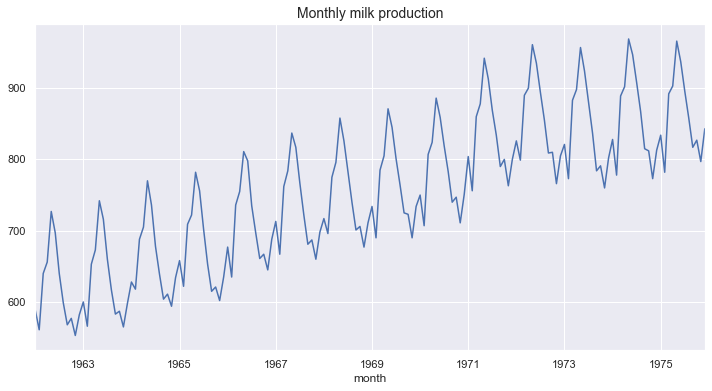

In [3]:
plt.figure(figsize=(12,6))
data['milk'].plot()
plt.title('Monthly milk production', fontsize=14)
plt.show()

Проверим гипотезу о стационарности ряда критерием Дики-Фуллера:

$H_0$: ряд нестационарен

$H_1$: ряд стационарен

In [4]:
print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data['milk'])[1]:.4f}")

Dickey-Fuller test: p-value = 0.6274


Нулевая гипотеза $H_0$ не отвергается, p-value > $\alpha=0.05$, ряд нестационарен

In [5]:
data['days_in_month'] = data.index.map(lambda x: monthrange(x.year, x.month)[1])
data['daily_milk'] = data.milk / data.days_in_month
data.head()

,milk,days_in_month,daily_milk
month,,,
1962-01-01,589,31,19.000000
1962-02-01,561,28,20.035714
1962-03-01,640,31,20.645161
1962-04-01,656,30,21.866667
1962-05-01,727,31,23.451613


In [6]:
print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data['daily_milk'])[1]:.4f}")

Dickey-Fuller test: p-value = 0.6822


Нулевая гипотеза $H_0$ не отвергается, p-value > $\alpha=0.05$, ряд нестационарен

#### 2. Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

Дифференцирование можно делать так:

<center><code>data.daily_diff1 = data.daily_milk - data.daily_milk.shift(1)</code></center>

Чтобы сделать сезонное дифференцирование, нужно изменить значение параметра у функции shift:

<center><code>data.daily_diff12 = data.daily_milk - data.daily_milk.shift(12)</code></center>

При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости.

Итак, какое дифференцирование делает ряд стационарным?

In [7]:
data['daily_milk_diff_12'] = data['daily_milk'] - data['daily_milk'].shift(12)

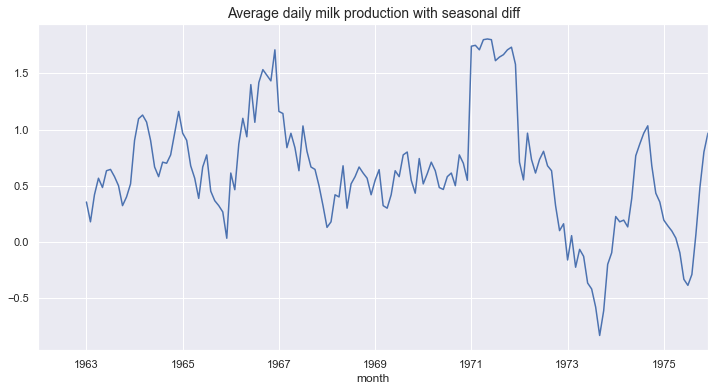

In [8]:
plt.figure(figsize=(12,6))
data['daily_milk_diff_12'].plot()
plt.title('Average daily milk production with seasonal diff', fontsize=14)
plt.show()

Проверим гипотезу о стационарности ряда критерием Дики-Фуллера:

$H_0$: ряд нестационарен

$H_1$: ряд стационарен

In [9]:
print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data['daily_milk_diff_12'].dropna())[1]:.4f}")

Dickey-Fuller test: p-value = 0.2213


Нулевая гипотеза $H_0$ не отвергается, p-value > $\alpha=0.05$, ряд нестационарен

Продифференцируем ряд, до тех пор, пока $H_0$ не отвергается в пользу альтернативы $H_1$:

In [10]:
data['daily_milk_diff_12_1'] = data['daily_milk_diff_12'] - data['daily_milk_diff_12'].shift(1)

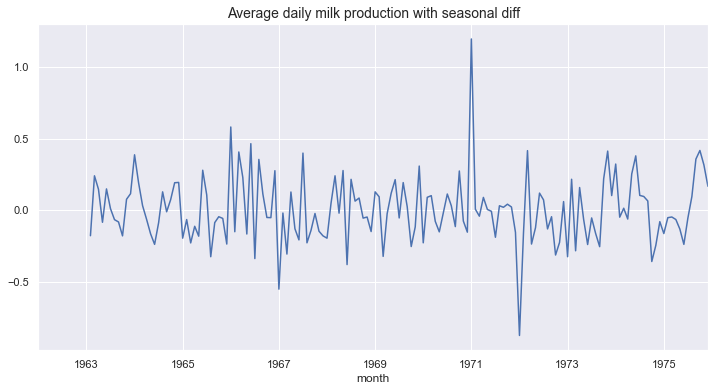

In [11]:
plt.figure(figsize=(12,6))
data['daily_milk_diff_12_1'].plot()
plt.title('Average daily milk production with seasonal diff', fontsize=14)
plt.show()

In [12]:
print(f"Dickey-Fuller test: p-value = {sm.tsa.stattools.adfuller(data['daily_milk_diff_12_1'].dropna())[1]}")

Dickey-Fuller test: p-value = 2.2808455518037347e-06


Нулевая гипотеза $H_0$ отвергается в пользу альтернативы $H_1$, p-value < $\alpha=0.05$, ряд стационарен

#### 3. Для стационарного ряда из предыдущего вопроса (продифференцированного столько раз, сколько вы посчитали нужным) постройте график автокорреляционной функции. Это можно cделать так: <br>
<center><code>import statsmodels.api as sm
sm.graphics.tsa.plot_acf(ряд.values.squeeze(), lags=50)</code></center>

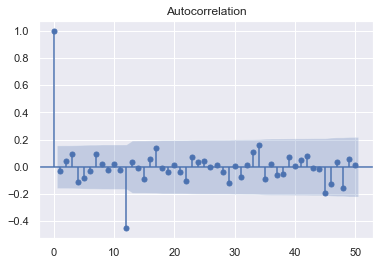

In [13]:
sm.graphics.tsa.plot_acf(data['daily_milk_diff_12_1'].dropna().values.squeeze(), lags=50)
plt.show()

#### 4. Для того же ряда, что и в предыдущем вопросе, постройте график частичной автокорреляционной функции. Это можно сделать так: <br>
<center><code>import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(ряд.values.squeeze(), lags=50)</code></center>

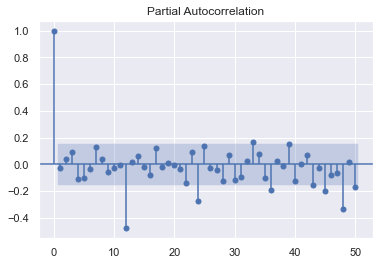

In [14]:
sm.graphics.tsa.plot_pacf(data['daily_milk_diff_12_1'].dropna().values.squeeze(), lags=50)
plt.show()